In [27]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


In [28]:
df = pd.read_csv("pokemon_data.csv", index_col = "Name")
df.head()

,Passes,Smashes
Name,,
Bulbasaur,1187934,331851
Ivysaur,1172763,303853
Venusaur,1175757,273495
Charmander,1152826,271930
Charmeleon,1135715,275524


In [29]:
df['Smash Scaled'] = (df['Smashes'] - df['Smashes'].min()) / (df['Smashes'].max() - df['Smashes'].min())
df['Pass Scaled'] = (df['Passes'] - df['Passes'].min()) / (df['Passes'].max() - df['Passes'].min())


# Ensure Total = 1 for each row
df['Total'] = df['Smash Scaled'] + df['Pass Scaled']
df['Pass Normalized'] = df['Pass Scaled'] / df['Total']
df['Smash Normalized'] = df['Smash Scaled'] / df['Total']

In [30]:

def load_and_process_image(name, img_size=(224, 224)):
    img_path = os.path.join('images', f'{name}.png')  # Build path from name
    if os.path.exists(img_path):
        # Read the image with alpha channel
        img_original = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        
        # Create mask for transparent pixels and set them to white
        if img_original.shape[2] == 4:  # Check if it has 4 channels (RGBA)
            mask = img_original[:, :, 3] == 0
            img_original[mask] = [255, 255, 255, 255]
        
        # Convert to RGB (ignores alpha channel)
        img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGRA2RGB)
        
        # Resize the image
        img_resized = cv2.resize(img_rgb, img_size,interpolation=cv2.INTER_AREA)
        
        return img_resized
    else:
        print(f"Warning: Image for {name} not found.")
        return np.zeros(img_size + (3,))  # Return a blank image if not found

# Load and process all images
image_arrays = [load_and_process_image(name) for name in df.index]

# Flatten images to 1D arrays
X_images = np.array([img.flatten() for img in image_arrays])

# Normalize pixel values to [0, 1]
X_images = X_images / 255.0

# Labels (target)
y = df['Smash Normalized']




In [ ]:
# Define the Sequential model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_images.shape[1],)),  # Flattened image input size
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_images, y, epochs=30, batch_size=32, validation_split=0.2)



Epoch 1/30


ValueError: in user code:

    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 150528)


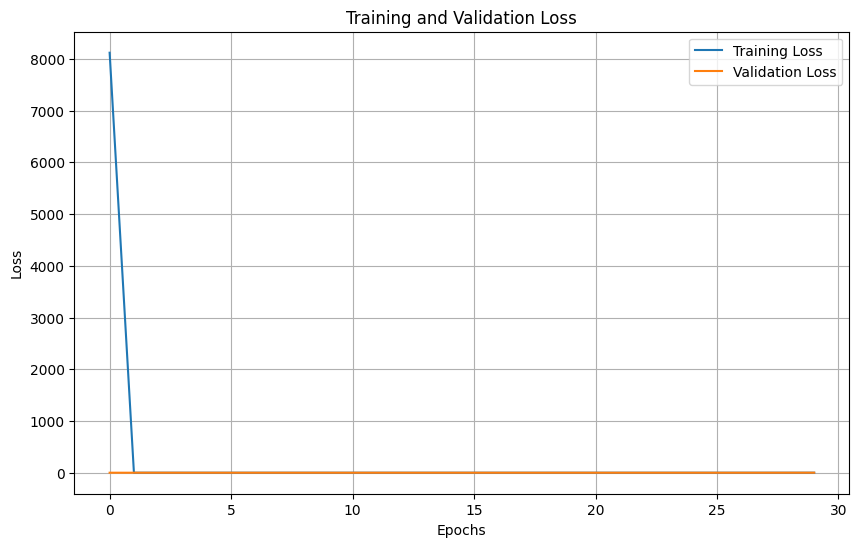

In [ ]:

# Extract loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Predict Smash scores based on images
predictions = model.predict(X_images)

# Add the predicted scores to the DataFrame
df['Predicted Smash Score'] = predictions


33/33 [==============================] - 0s 11ms/step


In [ ]:
df.head(100)

,Passes,Smashes,Smash Scaled,Pass Scaled,Total,Pass Normalized,Smash Normalized,Predicted Smash Score
Name,,,,,,,,
Bulbasaur,1187934,331851,0.408613,1.000000,1.408613,0.709918,0.290082,-0.536305
Ivysaur,1172763,303853,0.373735,0.987044,1.360779,0.725352,0.274648,-0.470944
Venusaur,1175757,273495,0.335917,0.989601,1.325518,0.746577,0.253423,-0.573765
Charmander,1152826,271930,0.333967,0.970017,1.303985,0.743887,0.256113,-0.496464
Charmeleon,1135715,275524,0.338445,0.955404,1.293849,0.738420,0.261580,-0.511837
...,...,...,...,...,...,...,...,...
Drowzee,877238,127281,0.153773,0.734662,0.888436,0.826917,0.173083,-0.454342
Hypno,794046,208450,0.254888,0.663616,0.918504,0.722496,0.277504,-0.490528
Krabby,914024,86006,0.102356,0.766078,0.868434,0.882138,0.117862,-0.605007
